In [1]:
from z3 import *
import matplotlib.pyplot as plt

Here we write the model at an RTT level. This method can only support calculating rates, and not calculating queuing delays. An alternate approach may allow us to calculate queuing delays (not not rates). Timesteps are in units of an RTT.

## Parameters
* $T$ - Number of RTTs to work for
* $B$ - BDP
* $K$ - Slack ($K = Ku - Kl, \forall t$)

**Note** This formulation only works if Only works if $K \ge C \cdot RTT = BDP$)

## Variables
If we wrote these variables in real time (instead of timesteps), think of them as right continuous
* $O_t$ - number of bytes output till timestep $t$ (not including wasted opportunities)
* $I_t$ - number of bytes input till timestep $t$
* $w_t$ - cwnd at the beginning of timestep $t$
* $Ku_t, Kl_t$ - upper and lower slack. Can change if the server decides to waste transmission opportunities

## Constraints
* $\min(I_{t-1}, B \cdot t - Kl_t) \le O_t \le B \cdot t + Ku_t$
* $I_t = I_{t-1} + \left[ O_{t-1} - O_{t-2} + w_t - w_{t-1} \right]^+$

In [224]:
s = Solver()

# Parameters of our system
T = 10
B = 10
K = B
# Otherwise our constraints are wrong
assert(K >= B)

# Create the variables
O = [Int("O_%d" % t) for t in range(T)]
I = [Int("I_%d" % t) for t in range(T)]
Ku = [Int("Ku_%d" % t) for t in range(T)]
Kl = [Int("Kl_%d" % t) for t in range(T)]
w = [Int("w_%d" % t) for t in range(T)]

# The constraints
for t in range(1, T):
    # Constrain the output
    #lower_t = If(B * t - Kl[t] < I[t-1], B * t - Kl[t], I[t-1])
    s.add(B * t - Kl[t] <= O[t])
    s.add(O[t] <= B * t + Ku[t])
    s.add(O[t-1] <= O[t])
    
    # Outputs and windows together decide how input changes
    if t > 1:
        I_change = O[t-1] - O[t-2] + w[t] - w[t-1]
        s.add(I[t] == I[t - 1] + If(I_change >= 0, I_change, 0))
    
    # Determine if we can waste transmissions
    waste_allowed = O[t] >= I[t-1]
    s.add(Implies(waste_allowed,
                  And(Ku[t] + B * t >= O[t],
                      Ku[t] <= Ku[t-1])))
    s.add(Implies(Not(waste_allowed),
                  And(Ku[t] == Ku[t-1],
                      Kl[t] == Kl[t-1])))
    s.add(Ku[t] + Kl[t] == K)
    s.add(I[t] >= O[t])
    #s.add(Ku[t] > 0)
    #s.add(Ku[t] < K)
    
    # Constant cwnd congestion control for now
    s.add(w[t] == w[t-1])

# Our objective
s.add(Ku[-1] < 0)

# Initial condition
s.add(O[0] == 0); s.add(O[1] == 0)
s.add(I[0] == w[0]); s.add(I[1] == w[0])
s.add(Ku[0] == 0); s.add(Kl[0] == K)
s.add(w[0] == 29)

In [225]:
s.check()

sat

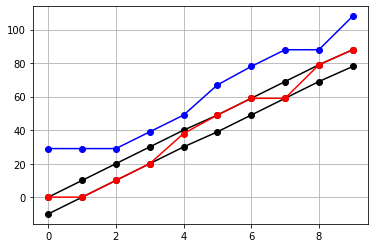

In [226]:
# Plot the model
m = s.model()
outputs = [m[o].as_long() for o in O]
inputs = [m[i].as_long() for i in I]
upper = [B * t + m[Ku[t]].as_long() for t in range(T)]
lower = [B * t - m[Kl[t]].as_long() for t in range(T)]
times = [t for t in range(T)]
plt.plot(times, lower, color='black', marker='o')
plt.plot(times, upper, color='black', marker='o')
plt.plot(times, outputs, color='red', marker='o')
plt.plot(times, inputs, color='blue', marker='o')
plt.grid(True)
#plt.yticks(range(20, 70, 5))
#plt.xlim(3, 6)
#plt.ylim(20, 70)
plt.show()

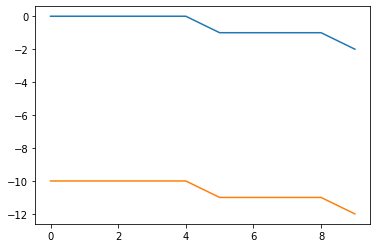

In [211]:
upper = [m[Ku[t]].as_long() for t in range(T)]
lower = [- m[Kl[t]].as_long() for t in range(T)]
times = [t for t in range(T)]
plt.plot(times, upper)
plt.plot(times, lower)

In [193]:
print([x for x in zip(outputs, inputs)])

[(0, 25), (0, 25), (10, 25), (20, 35), (30, 45), (45, 55), (53, 70), (62, 78), (78, 87), (87, 103)]
